# module 1.5 - reaction mechanism

In [1]:
"""
An example demonstrating how to use Species and Reaction objects to
programmatically extract a reaction submechanism. In this example, the CO/H2
oxidation reactions are extracted from the GRI 3.0 mechanism.

To test the submechanism, a premixed CO/H2 flame is simulated using the original
mechanism and the submechanism, which demonstrates that the submechanism
contains all of the important species and reactions.
"""

from timeit import default_timer
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_species = ct.Species.listFromFile('gri30.xml')
species = []

# Filter species
for S in all_species:
    comp = S.composition
    if 'C' in comp and 'H' in comp:
        # Exclude all hydrocarbon species
        continue
    if 'N' in comp and comp != {'N':2}:
        # Exclude all nitrogen compounds except for N2
        continue
    if 'Ar' in comp:
        # Exclude Argon
        continue

    species.append(S)

species_names = {S.name for S in species}
print('Species: {0}'.format(', '.join(S.name for S in species)))

# Filter reactions, keeping only those that only involve the selected species
all_reactions = ct.Reaction.listFromFile('gri30.xml')
reactions = []

print('\nReactions:')
for R in all_reactions:
    if not all(reactant in species_names for reactant in R.reactants):
        continue

    if not all(product in species_names for product in R.products):
        continue

    reactions.append(R)
    print(R.equation)
print('\n')

Species: H2, H, O, O2, OH, H2O, HO2, H2O2, C, CO, CO2, N2

Reactions:
2 O + M <=> O2 + M
H + O + M <=> OH + M
H2 + O <=> H + OH
HO2 + O <=> O2 + OH
H2O2 + O <=> HO2 + OH
CO + O (+M) <=> CO2 (+M)
CO + O2 <=> CO2 + O
H + O2 + M <=> HO2 + M
H + 2 O2 <=> HO2 + O2
H + H2O + O2 <=> H2O + HO2
H + N2 + O2 <=> HO2 + N2
H + O2 <=> O + OH
2 H + M <=> H2 + M
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
CO2 + 2 H <=> CO2 + H2
H + OH + M <=> H2O + M
H + HO2 <=> H2O + O
H + HO2 <=> H2 + O2
H + HO2 <=> 2 OH
H + H2O2 <=> H2 + HO2
H + H2O2 <=> H2O + OH
H2 + OH <=> H + H2O
2 OH (+M) <=> H2O2 (+M)
2 OH <=> H2O + O
HO2 + OH <=> H2O + O2
H2O2 + OH <=> H2O + HO2
H2O2 + OH <=> H2O + HO2
C + OH <=> CO + H
CO + OH <=> CO2 + H
2 HO2 <=> H2O2 + O2
2 HO2 <=> H2O2 + O2
CO + HO2 <=> CO2 + OH
C + O2 <=> CO + O
HO2 + OH <=> H2O + O2




gas1 contains the complete GRI 3.0 mechanism stored in the file and gas2 contains the hydrogen submechanism that we just created.

In [3]:
gas1 = ct.Solution('gri30.xml')
gas2 = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                   species=species, reactions=reactions)

We define a function that we can call to compute a low pressure premixed counterflow flame of hydrogen, CO, and air

In [4]:
def solve_flame(gas):
    gas.TPX = 373, 0.05*ct.one_atm, 'H2:0.4, CO:0.6, O2:1, N2:3.76'

    # Create the flame simulation object
    sim = ct.CounterflowPremixedFlame(gas=gas, width=0.2)

    sim.reactants.mdot = 0.12 # kg/m^2/s
    sim.products.mdot = 0.06 # kg/m^2/s

    sim.set_refine_criteria(ratio=3, slope=0.1, curve=0.2)
    sim.solve(0, auto=True)
    return sim

In [5]:
# we solve the flame problem with the GRi 3.0 mechanism, this will take maybe 15 seconds
t1 = default_timer()
sim1 = solve_flame(gas1)
t2 = default_timer()
print('Solved with GRI 3.0 in {0:.2f} seconds'.format(t2-t1))

Solved with GRI 3.0 in 13.03 seconds


In [6]:
# solve with the reduced mechanism
t1 = default_timer()
sim2 = solve_flame(gas2)
t2 = default_timer()
print('Solved with CO/H2 submechanism in {0:.2f} seconds'.format(t2-t1))

Solved with CO/H2 submechanism in 0.61 seconds


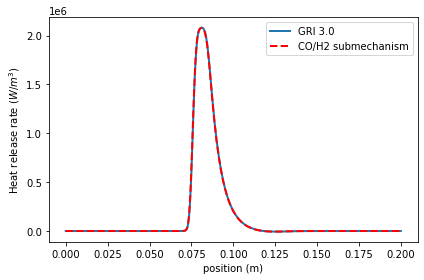

In [7]:
plt.plot(sim1.grid, sim1.heat_release_rate,
         lw=2, label='GRI 3.0')

plt.plot(sim2.grid, sim2.heat_release_rate,
         'r--', lw=2, label='CO/H2 submechanism')

plt.ylabel('Heat release rate ($W/m^3$)')
plt.xlabel('position (m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Mechanism reduction part 2
In the previous exercise we just removed hydrocarbon and nitrogen reactions. We can do better than that

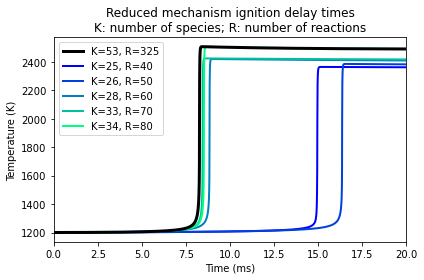

In [8]:
"""
A simplistic approach to mechanism reduction which demonstrates Cantera's
features for dynamically manipulating chemical mechanisms.

Here, we use the full GRI 3.0 mechanism to simulate adiabatic, constant pressure
ignition of a lean methane/air mixture. We track the maximum reaction rates for
each reaction to determine which reactions are the most important, according to
a simple metric based on the relative net reaction rate.

We then create a sequence of reduced mechanisms including only the top reactions
and the associated species, and run the simulations again with these mechanisms
to see whether the reduced mechanisms with a certain number of species are able
to adequately simulate the ignition delay problem.
"""

gas = ct.Solution('gri30.xml')
initial_state = 1200, 5 * ct.one_atm, 'CH4:0.35, O2:1.0, N2:3.76'

# Run a simulation with the full mechanism
gas.TPX = initial_state
r = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

tt = []
TT = []
t = 0.0
# Rmax is the maximum relative reaction rate at any timestep
Rmax = np.zeros(gas.n_reactions)
while t < 0.02:
    t = sim.step()
    tt.append(1000 * t)
    TT.append(r.T)
    rnet = abs(gas.net_rates_of_progress)
    rnet /= max(rnet)
    Rmax = np.maximum(Rmax, rnet)

# store result    
#time_1 = tt
#Temp_1 = TT

plt.plot(tt, TT, label='K=53, R=325', color='k', lw=3, zorder=100)
# Get the reaction objects, and sort them so the most active reactions are first
R = sorted(zip(Rmax, gas.reactions()), key=lambda x: -x[0])

# Test reduced mechanisms with different numbers of reactions
C = plt.cm.winter(np.linspace(0,1,5))

# retrieve the N most reactive reactions 
# we then have to find out how many species belong to this
for i,N in enumerate([40,50,60,70,80]):
    # Get the N most active reactions
    reactions = [r[1] for r in R[:N]]

    # find the species involved in these reactions. At a minimum, include all
    # species in the reactant mixture
    species_names = {'N2', 'CH4', 'O2'}
    for reaction in reactions:
        species_names.update(reaction.reactants)
        species_names.update(reaction.products)

    # Get the species objects
    species = [gas.species(name) for name in species_names]

    # create the new reduced mechanism
    gas2 = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

    # Re-run the ignition problem with the reduced mechanism
    gas2.TPX = initial_state
    r = ct.IdealGasConstPressureReactor(gas2)
    sim = ct.ReactorNet([r])

    t = 0.0

    tt = []
    TT = []
    while t < 0.02:
        t = sim.step()
        tt.append(1000 * t)
        TT.append(r.T)

    plt.plot(tt,TT, lw=2, color=C[i],
             label='K={0}, R={1}'.format(gas2.n_species, N))
    plt.xlabel('Time (ms)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='upper left')
    plt.title('Reduced mechanism ignition delay times\n'
              'K: number of species; R: number of reactions')
    plt.xlim(0, 20)
    plt.tight_layout()

plt.show()